In [1]:
# Name: Jinwei Hu
# Username: ACSE-jh4322

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
import shap
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import lime
from lime import lime_tabular
import numpy as np


# Load Data

In [2]:
# read csv
dataset = pd.read_csv('data/updated_coalescence.csv')

# use min-max normalization
scaler = preprocessing.MinMaxScaler()

# split data and label
data = dataset.iloc[:, :5]
data

,D/W 1,D/W 2,"dt, ms",flow,Heff
0,0.439492,0.444841,165,14.0,161
1,0.427011,0.455538,270,14.0,161
2,0.473368,0.444841,265,14.0,161
3,0.480499,0.433252,236,14.0,161
4,0.472476,0.436817,94,14.0,161
...,...,...,...,...,...
1496,0.461569,0.480358,309,20.0,154
1497,0.487384,0.499938,103,20.0,154
1498,0.457170,0.582460,66,20.0,154
1499,0.507087,0.486507,318,20.0,154


In [3]:
# preprocess D/W 1 and D/W 2
data['D/W 1 + D/W 2'] = data['D/W 1'] + data['D/W 2']
data['|D/W 1 - D/W 2|'] = abs(data['D/W 1'] - data['D/W 2'])
data

,D/W 1,D/W 2,"dt, ms",flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,0.439492,0.444841,165,14.0,161,0.884333,0.005349
1,0.427011,0.455538,270,14.0,161,0.882550,0.028527
2,0.473368,0.444841,265,14.0,161,0.918208,0.028527
3,0.480499,0.433252,236,14.0,161,0.913751,0.047248
4,0.472476,0.436817,94,14.0,161,0.909294,0.035659
...,...,...,...,...,...,...,...
1496,0.461569,0.480358,309,20.0,154,0.941928,0.018789
1497,0.487384,0.499938,103,20.0,154,0.987322,0.012555
1498,0.457170,0.582460,66,20.0,154,1.039629,0.125290
1499,0.507087,0.486507,318,20.0,154,0.993594,0.020581


In [4]:
# Get final data
data = data.iloc[:, 2:]
# data = data.iloc[:, [2, 3, 6, 7]]
data

,"dt, ms",flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,165,14.0,161,0.884333,0.005349
1,270,14.0,161,0.882550,0.028527
2,265,14.0,161,0.918208,0.028527
3,236,14.0,161,0.913751,0.047248
4,94,14.0,161,0.909294,0.035659
...,...,...,...,...,...
1496,309,20.0,154,0.941928,0.018789
1497,103,20.0,154,0.987322,0.012555
1498,66,20.0,154,1.039629,0.125290
1499,318,20.0,154,0.993594,0.020581


In [5]:
# min-max normalization
normalized_data = scaler.fit_transform(data)
columns = ['dt', 'flow', 'Heff', 'D/W 1 + D/W 2', '|D/W 1 - D/W 2|']
# convert to dataframe
normalized_data = pd.DataFrame(normalized_data, columns=columns)
normalized_data

,dt,flow,Heff,D/W 1 + D/W 2,|D/W 1 - D/W 2|
0,0.202719,0.076923,0.343284,0.251599,0.024036
1,0.332509,0.076923,0.343284,0.247751,0.128192
2,0.326329,0.076923,0.343284,0.324722,0.128192
3,0.290482,0.076923,0.343284,0.315100,0.212318
4,0.114957,0.076923,0.343284,0.305479,0.160240
...,...,...,...,...,...
1496,0.380717,1.000000,0.291045,0.375921,0.084432
1497,0.126082,1.000000,0.291045,0.473907,0.056418
1498,0.080346,1.000000,0.291045,0.586815,0.563020
1499,0.391842,1.000000,0.291045,0.487446,0.092484


In [6]:
# get label
label = dataset.iloc[:, 5]
# modify label 'Y': 1, 'N': 0
label = label.replace({'Y': 1, 'N': 0, 'y': 1})
label

0       1
1       1
2       1
3       1
4       1
       ..
1496    0
1497    0
1498    0
1499    0
1500    0
Name: Coalescence, Length: 1501, dtype: int64

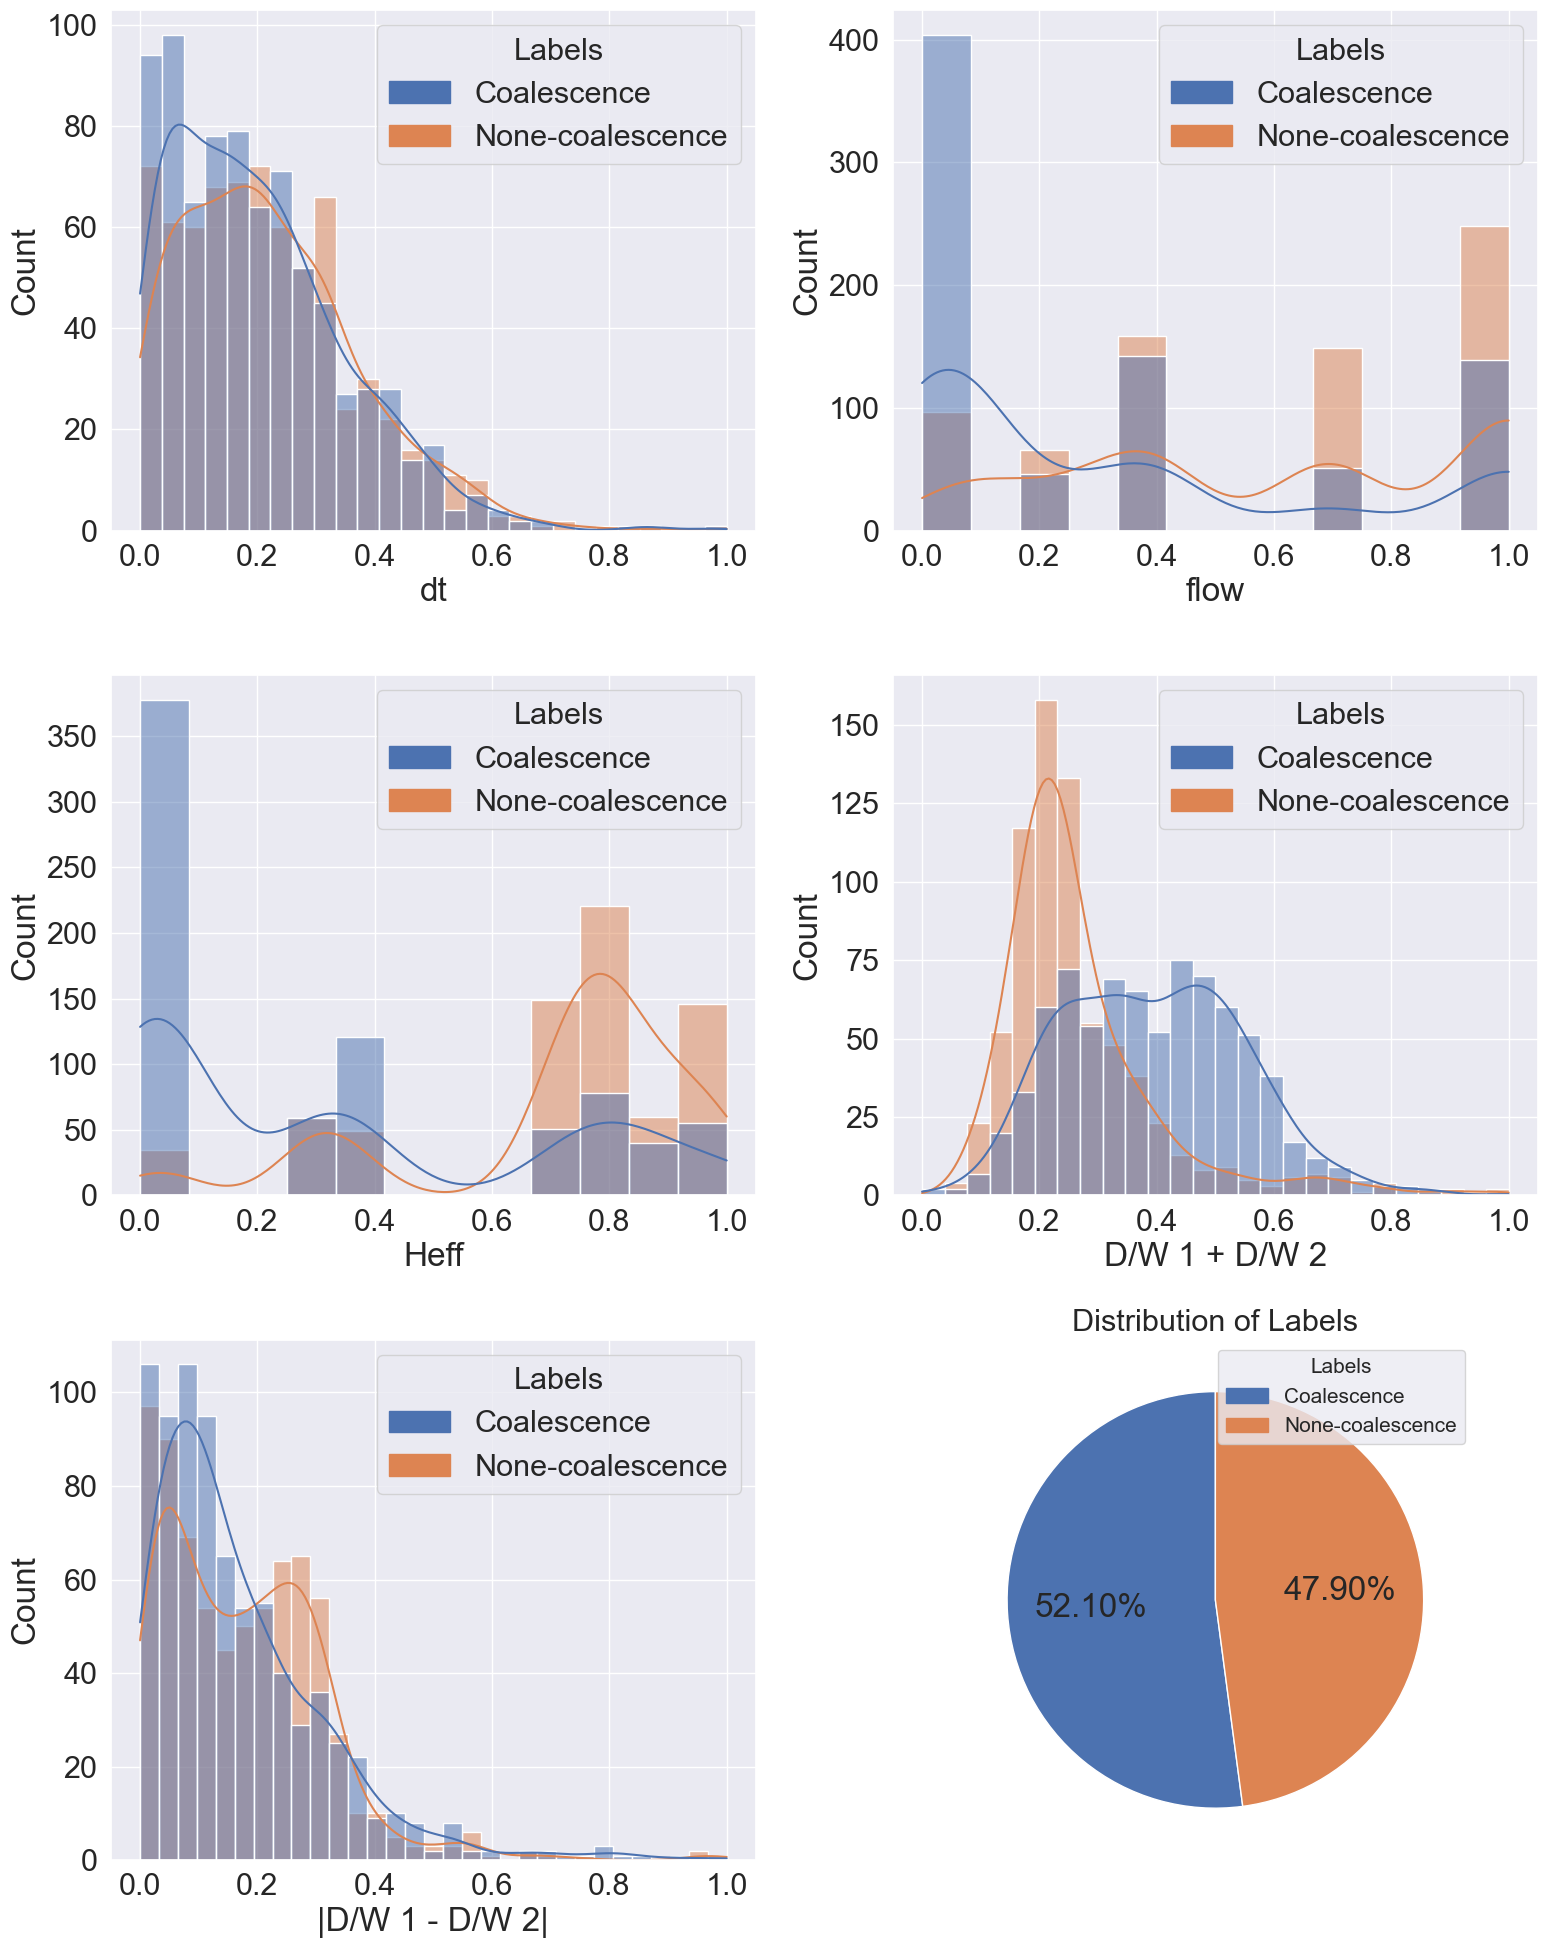

In [7]:
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 24})

normalized_data_copy = normalized_data.copy()
# map number to labels
label_dict = {1: 'Coalescence', 0: 'None-coalescence'}
normalized_data_copy['label'] = label.map(label_dict)

# define column names
features = ['dt', 'flow', 'Heff', 'D/W 1 + D/W 2', '|D/W 1 - D/W 2|']

# plot data distribution
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 20))

# set default color
default_colors = sns.color_palette()
patch1 = mpatches.Patch(color=default_colors[0], label='Coalescence')
patch2 = mpatches.Patch(color=default_colors[1], label='None-coalescence')
legend_handles = [patch1, patch2]

for idx, feature in enumerate(features):
    row = idx // 2
    col = idx % 2
    sns.histplot(data=normalized_data_copy, x=feature, hue='label', kde=True, ax=axes[row, col])
    axes[row, col].set_xlabel(feature, fontsize=24)  
    axes[row, col].set_ylabel('Count', fontsize=24)  
    axes[row, col].tick_params(axis='both', labelsize=22) 
    axes[row, col].legend(handles=legend_handles, title="Labels", title_fontsize='22', fontsize='22')  

# draw pie chart
labels_counts = normalized_data_copy['label'].value_counts()
axes[2, 1].pie(labels_counts, labels=None, autopct='%1.2f%%', startangle=90, colors=default_colors[:2])
axes[2, 1].set_title('Distribution of Labels', fontsize=22) 
axes[2, 1].legend(handles=legend_handles, title="Labels", title_fontsize='15', fontsize='15')

plt.tight_layout()
plt.show()



In [8]:
print(label.value_counts())

Coalescence
1    782
0    719
Name: count, dtype: int64


In [9]:
# split train, valid, test dataset
X_train, X_test, y_train, y_test = train_test_split(normalized_data, label, test_size=0.2, random_state=42, shuffle=True, stratify=label)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=True)

# store new datasets to csv files
X_train.to_csv('data/train_data.csv', index=False)
# X_valid.to_csv('data/valid_data.csv', index=False)
X_test.to_csv('data/test_data.csv', index=False)
y_train.to_csv('data/train_label.csv', index=False)
# y_valid.to_csv('data/valid_label.csv', index=False)
y_test.to_csv('data/test_label.csv', index=False)

# check their shape
print("train:", X_train.shape)
# print("valid:", X_valid.shape)
print("test:", X_test.shape)

train: (1200, 5)
test: (301, 5)


In [10]:
# check label distribution in train set
print(y_train.value_counts())

Coalescence
1    625
0    575
Name: count, dtype: int64


In [11]:
# check label distribution in test set
print(y_test.value_counts())

Coalescence
1    157
0    144
Name: count, dtype: int64


# MLP

In [12]:
from tensorflow.keras import optimizers
from sklearn.model_selection import StratifiedKFold
from tensorflow.errors import InvalidArgumentError

def create_model(activation='relu', learning_rates=0.01, dropout_rate=0.1, l2_rate=0.01, optimizer=optimizers.Adam):
    model = Sequential()
    model.add(Dense(256, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate), input_shape=(5,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(32, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(16, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_rate)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=learning_rates), metrics=['accuracy'])
    return model


# Grid Search and Cross Validation for MLP

In [13]:
# if want to use Grid Search, convert dataframe to numpy array firstly
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

In [ ]:
# Grid Search

# best model saved path
best_model_path = 'best_model2'

# define hyperparameters
activation_functions = ['relu', 'tanh', 'linear']
optimizers_map = {'adam': optimizers.Adam, 'sgd': optimizers.SGD, 'rmsprop': optimizers.RMSprop}
learning_rates = [0.001, 0.01, 0.1]
l2_rates = [0.0, 0.001, 0.01, 0.1]
dropout_rates = [0.0, 0.1, 0.2, 0.3]
epochs_options = [10, 50, 100, 150, 200, 250, 300, 400, 450, 500]

# k-fold
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# store validation results
best_val_acc = 0
best_params = {} 

for activation in activation_functions:
    for optimizer_key in optimizers_map:
        optimizer = optimizers_map[optimizer_key]
        for learning_rate in learning_rates:
            for l2 in l2_rates:
                for dropout_rate in dropout_rates:
                    for epochs in epochs_options:
                        val_acc_list = []  # record accuracy for every cross validation
                        for train, val in kfold.split(X_train_np, y_train_np):
                            try:
                                model = create_model(activation=activation, learning_rates=learning_rate, l2_rate = l2, dropout_rate=dropout_rate, optimizer=optimizer)
                                model.fit(X_train_np[train], y_train_np[train], epochs=epochs, verbose=0)
                                _, val_acc = model.evaluate(X_train_np[val], y_train_np[val], verbose=0)
                                val_acc_list.append(val_acc)
                            except InvalidArgumentError:
                                print(f'Skipped due to InvalidArgumentError with settings: optimizer={optimizer_key}, activation={activation}, learning rate={learning_rate}, l2_rate={l2}, dropout rate={dropout_rate}, epochs={epochs}')
                                continue
                        mean_val_acc = np.mean(val_acc_list)  # calculate average accuracy
                        print(f'Current settings: mean_val_acc={mean_val_acc}, optimizer={optimizer_key}, activation={activation}, learning rate={learning_rate}, l2_rate={l2}, dropout rate={dropout_rate}, epochs={epochs}')
                        # update
                        if mean_val_acc > best_val_acc:
                            best_val_acc = mean_val_acc
                            best_params = {'activation': activation, 'optimizer': optimizer_key, 'learning_rate': learning_rate, 'l2_rate': l2,'dropout_rate': dropout_rate, 'epochs': epochs}
                            print(f'Best validation accuracy: {best_val_acc} | Params: {best_params}')
                            # save best model
                            model.save(best_model_path)

print(f'Best validation accuracy: {best_val_acc} | Params: {best_params}')
# train on best hyperparameters
model = create_model(activation=best_params['activation'], learning_rates=best_params['learning_rate'], l2_rate=best_params['l2_rate'], dropout_rate=best_params['dropout_rate'], optimizer=optimizers_map[best_params['optimizer']])
model.fit(X_train_np, y_train_np, epochs=best_params['epochs'])

# test on test set
_, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Current settings: mean_val_acc=0.7508333325386047, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=10
Best validation accuracy: 0.7508333325386047 | Params: {'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'l2_rate': 0.0, 'dropout_rate': 0.0, 'epochs': 10}
INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


Current settings: mean_val_acc=0.7641666650772094, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=50
Best validation accuracy: 0.7641666650772094 | Params: {'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'l2_rate': 0.0, 'dropout_rate': 0.0, 'epochs': 50}
INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


Current settings: mean_val_acc=0.7441666603088379, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=100
Current settings: mean_val_acc=0.7383333206176758, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=150
Current settings: mean_val_acc=0.7316666722297669, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=200
Current settings: mean_val_acc=0.728333342075348, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=250
Current settings: mean_val_acc=0.721666669845581, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=300
Current settings: mean_val_acc=0.7183333396911621, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=400
Current settings: mean_val_acc=0.7300000071525574, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.0, dr

INFO:tensorflow:Assets written to: best_model2/assets


Current settings: mean_val_acc=0.7650000095367432, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.0, epochs=150
Best validation accuracy: 0.7650000095367432 | Params: {'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'l2_rate': 0.001, 'dropout_rate': 0.0, 'epochs': 150}
INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


Current settings: mean_val_acc=0.7541666626930237, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.0, epochs=200
Current settings: mean_val_acc=0.7716666698455811, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.0, epochs=250
Best validation accuracy: 0.7716666698455811 | Params: {'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'l2_rate': 0.001, 'dropout_rate': 0.0, 'epochs': 250}
INFO:tensorflow:Assets written to: best_model2/assets


INFO:tensorflow:Assets written to: best_model2/assets


Current settings: mean_val_acc=0.7516666650772095, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.0, epochs=300
Current settings: mean_val_acc=0.7491666674613953, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.0, epochs=400
Current settings: mean_val_acc=0.7516666650772095, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.0, epochs=450
Current settings: mean_val_acc=0.7416666746139526, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.0, epochs=500
Current settings: mean_val_acc=0.7433333396911621, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.1, epochs=10
Current settings: mean_val_acc=0.7675000071525574, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.1, epochs=50
Current settings: mean_val_acc=0.7433333396911621, optimizer=adam, activation=relu, learning rate=0.001, l2_

Current settings: mean_val_acc=0.7283333301544189, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.2, epochs=100
Current settings: mean_val_acc=0.7349999904632568, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.2, epochs=150
Current settings: mean_val_acc=0.7366666674613953, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.2, epochs=200
Current settings: mean_val_acc=0.7308333277702331, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.2, epochs=250
Current settings: mean_val_acc=0.7416666865348815, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.2, epochs=300
Current settings: mean_val_acc=0.7425000071525574, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.2, epochs=400
Current settings: mean_val_acc=0.721666669845581, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=

Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.3, epochs=400
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.3, epochs=450
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.3, epochs=500
Current settings: mean_val_acc=0.7424999952316285, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.0, epochs=10
Current settings: mean_val_acc=0.7566666722297668, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.0, epochs=50
Current settings: mean_val_acc=0.7641666650772094, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.0, epochs=100
Current settings: mean_val_acc=0.7341666698455811, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropou

2023-07-24 20:18:56.745629: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at resource_variable_ops.cc:597 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.


Skipped due to InvalidArgumentError with settings: optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.2, epochs=500
Current settings: mean_val_acc=0.7312500029802322, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.2, epochs=500
Current settings: mean_val_acc=0.7408333420753479, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=10
Current settings: mean_val_acc=0.7449999928474427, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=50
Current settings: mean_val_acc=0.7533333420753479, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=100
Current settings: mean_val_acc=0.7400000095367432, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=150
Current settings: mean_val_acc=0.7458333373069763, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.0, dropout r

Current settings: mean_val_acc=0.7333333373069764, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.0, epochs=200
Current settings: mean_val_acc=0.6450000047683716, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.0, epochs=250
Current settings: mean_val_acc=0.684166669845581, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.0, epochs=300
Current settings: mean_val_acc=0.65, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.0, epochs=400
Current settings: mean_val_acc=0.6566666603088379, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.0, epochs=450
Current settings: mean_val_acc=0.7350000023841858, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.0, epochs=500
Current settings: mean_val_acc=0.7291666746139527, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.

Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.2, epochs=10
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.2, epochs=50
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.2, epochs=100
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.2, epochs=150
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.2, epochs=200
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.2, epochs=250
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.01, l2_rate=0.1, dropout r

Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.3, epochs=250
Current settings: mean_val_acc=0.5124999821186066, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.3, epochs=300
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.3, epochs=400
Current settings: mean_val_acc=0.5124999821186066, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.3, epochs=450
Current settings: mean_val_acc=0.5124999821186066, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.3, epochs=500
Current settings: mean_val_acc=0.549999988079071, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.001, dropout rate=0.0, epochs=10
Current settings: mean_val_acc=0.6691666543483734, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.001, dropout rate

Current settings: mean_val_acc=0.5041666507720948, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.0, epochs=500
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.1, epochs=10
Current settings: mean_val_acc=0.5041666507720948, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.1, epochs=50
Current settings: mean_val_acc=0.5124999821186066, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.1, epochs=100
Current settings: mean_val_acc=0.5124999821186066, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.1, epochs=150
Current settings: mean_val_acc=0.5041666507720948, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.1, epochs=200
Current settings: mean_val_acc=0.5041666507720948, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout r

2023-07-24 21:59:20.988343: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at resource_variable_ops.cc:597 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.


Skipped due to InvalidArgumentError with settings: optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.2, epochs=300
Current settings: mean_val_acc=0.4999999850988388, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.2, epochs=300
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.2, epochs=400
Current settings: mean_val_acc=0.5208333134651184, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.2, epochs=450
Current settings: mean_val_acc=0.5124999821186066, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.2, epochs=500
Current settings: mean_val_acc=0.5124999821186066, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.3, epochs=10
Current settings: mean_val_acc=0.4958333194255829, optimizer=adam, activation=relu, learning rate=0.1, l2_rate=0.01, dropout 

Current settings: mean_val_acc=0.7399999976158143, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=100
Current settings: mean_val_acc=0.7358333468437195, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=150
Current settings: mean_val_acc=0.7358333349227906, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=200
Current settings: mean_val_acc=0.7366666674613953, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=250
Current settings: mean_val_acc=0.7383333325386048, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=300
Current settings: mean_val_acc=0.7391666650772095, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.0, epochs=400
Current settings: mean_val_acc=0.737499988079071, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.0, dropout 

Current settings: mean_val_acc=0.7400000095367432, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.1, epochs=500
Current settings: mean_val_acc=0.5349999904632569, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.2, epochs=10
Current settings: mean_val_acc=0.6508333325386048, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.2, epochs=50
Current settings: mean_val_acc=0.7316666603088379, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.2, epochs=100
Current settings: mean_val_acc=0.7408333420753479, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.2, epochs=150
Current settings: mean_val_acc=0.7375, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.001, dropout rate=0.2, epochs=200
Current settings: mean_val_acc=0.7350000143051147, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.001, dropout

Current settings: mean_val_acc=0.728333342075348, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.3, epochs=250
Current settings: mean_val_acc=0.7425000071525574, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.3, epochs=300
Current settings: mean_val_acc=0.7416666626930237, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.3, epochs=400
Current settings: mean_val_acc=0.73416668176651, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.3, epochs=450
Current settings: mean_val_acc=0.7299999952316284, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.3, epochs=500
Current settings: mean_val_acc=0.5824999928474426, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.0, epochs=10
Current settings: mean_val_acc=0.5633333206176758, optimizer=sgd, activation=relu, learning rate=0.001, l2_rate=0.1, dropou

Current settings: mean_val_acc=0.7508333325386047, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.1, epochs=100
Current settings: mean_val_acc=0.7391666650772095, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.1, epochs=150
Current settings: mean_val_acc=0.762500011920929, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.1, epochs=200
Current settings: mean_val_acc=0.7508333325386047, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.1, epochs=250
Current settings: mean_val_acc=0.7566666603088379, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.1, epochs=300
Current settings: mean_val_acc=0.7591666579246521, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.1, epochs=400
Current settings: mean_val_acc=0.7616666674613952, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.

Current settings: mean_val_acc=0.759166669845581, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.001, dropout rate=0.2, epochs=450
Current settings: mean_val_acc=0.7583333253860474, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.001, dropout rate=0.2, epochs=500
Current settings: mean_val_acc=0.6716666579246521, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.001, dropout rate=0.3, epochs=10
Current settings: mean_val_acc=0.7333333373069764, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.001, dropout rate=0.3, epochs=50
Current settings: mean_val_acc=0.7383333325386048, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.001, dropout rate=0.3, epochs=100
Current settings: mean_val_acc=0.7424999952316285, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.001, dropout rate=0.3, epochs=150
Current settings: mean_val_acc=0.7566666603088379, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.001, dro

Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.0, epochs=250
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.0, epochs=300
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.0, epochs=400
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.0, epochs=450
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.0, epochs=500
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.1, epochs=10
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.01, l2_rate=0.1, dropout rate=0.

Current settings: mean_val_acc=0.7575000047683715, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.2, epochs=100
Current settings: mean_val_acc=0.7574999928474426, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.2, epochs=150
Current settings: mean_val_acc=0.7491666555404664, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.2, epochs=200
Current settings: mean_val_acc=0.7516666769981384, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.2, epochs=250
Current settings: mean_val_acc=0.7558333158493042, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.2, epochs=300
Current settings: mean_val_acc=0.7483333349227905, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.2, epochs=400
Current settings: mean_val_acc=0.7483333349227905, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.0, dropout rate=0.2, epo

Current settings: mean_val_acc=0.7533333420753479, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.001, dropout rate=0.3, epochs=450
Current settings: mean_val_acc=0.7591666579246521, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.001, dropout rate=0.3, epochs=500
Current settings: mean_val_acc=0.7391666650772095, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.0, epochs=10
Current settings: mean_val_acc=0.7474999904632569, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.0, epochs=50
Current settings: mean_val_acc=0.737500011920929, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.0, epochs=100
Current settings: mean_val_acc=0.737500011920929, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.0, epochs=150
Current settings: mean_val_acc=0.7241666674613952, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.01, dropout rate=0.0

Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.1, dropout rate=0.1, epochs=250
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.1, dropout rate=0.1, epochs=300
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.1, dropout rate=0.1, epochs=400
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.1, dropout rate=0.1, epochs=450
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.1, dropout rate=0.1, epochs=500
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.1, dropout rate=0.2, epochs=10
Current settings: mean_val_acc=0.5208333134651184, optimizer=sgd, activation=relu, learning rate=0.1, l2_rate=0.1, dropout rate=0.2, epoc

Current settings: mean_val_acc=0.7508333325386047, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.3, epochs=50
Current settings: mean_val_acc=0.7524999976158142, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.3, epochs=100
Current settings: mean_val_acc=0.7558333277702332, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.3, epochs=150
Current settings: mean_val_acc=0.7550000190734864, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.3, epochs=200
Current settings: mean_val_acc=0.7333333373069764, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.3, epochs=250
Current settings: mean_val_acc=0.7533333420753479, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.0, dropout rate=0.3, epochs=300
Current settings: mean_val_acc=0.7616666674613952, optimizer=rmsprop, activation=relu, learning rate=

Current settings: mean_val_acc=0.7341666698455811, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.0, epochs=300
Current settings: mean_val_acc=0.7433333277702332, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.0, epochs=400
Current settings: mean_val_acc=0.7341666698455811, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.0, epochs=450
Current settings: mean_val_acc=0.7450000047683716, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.0, epochs=500
Current settings: mean_val_acc=0.7458333373069763, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.1, epochs=10
Current settings: mean_val_acc=0.7258333325386047, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.01, dropout rate=0.1, epochs=50
Current settings: mean_val_acc=0.7449999928474427, optimizer=rmsprop, activation=relu, learning 

Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.2, epochs=10
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.2, epochs=50
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.2, epochs=100
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.2, epochs=150
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.2, epochs=200
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.001, l2_rate=0.1, dropout rate=0.2, epochs=250
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0

Current settings: mean_val_acc=0.7500000119209289, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=250
Current settings: mean_val_acc=0.7483333349227905, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=300
Current settings: mean_val_acc=0.7558333396911621, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=400
Current settings: mean_val_acc=0.7491666674613953, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=450
Current settings: mean_val_acc=0.7549999952316284, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.0, dropout rate=0.3, epochs=500
Current settings: mean_val_acc=0.7299999952316284, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.001, dropout rate=0.0, epochs=10
Current settings: mean_val_acc=0.7458333373069763, optimizer=rmsprop, activation=relu, learning rate=0.01

Current settings: mean_val_acc=0.5608333230018616, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.1, epochs=10
Current settings: mean_val_acc=0.5549999833106994, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.1, epochs=50
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.1, epochs=100
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.1, epochs=150
Current settings: mean_val_acc=0.5208333134651184, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.1, epochs=200
Current settings: mean_val_acc=0.5641666531562806, optimizer=rmsprop, activation=relu, learning rate=0.01, l2_rate=0.01, dropout rate=0.1, epochs=250
Current settings: mean_val_acc=0.6516666531562805, optimizer=rmsprop, activation=relu, learning rate=0

In [21]:
# from tensorflow.keras.models import load_model
# # load model
# best_model = load_model('best_model2')

# # test
# _, test_acc = best_model.evaluate(X_test, y_test)
# print(f'Test accuracy: {test_acc}')

10/10 [==============================] - 0s 628us/step - loss: 0.5663 - accuracy: 0.7409
Test accuracy: 0.7408638000488281


# Run Custom Model Directly

In [14]:
best_model = create_model(activation='relu', learning_rates=0.001, l2_rate=0.01, dropout_rate=0.1, optimizer=optimizers.Adam)
best_model.fit(X_train, y_train, epochs=2500)

# test
_, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/2500
38/38 [==============================] - 1s 962us/step - loss: 3.0308 - accuracy: 0.7092
Epoch 2/2500
38/38 [==============================] - 0s 904us/step - loss: 1.7199 - accuracy: 0.7375
Epoch 3/2500
38/38 [==============================] - 0s 913us/step - loss: 1.1501 - accuracy: 0.7367
Epoch 4/2500
38/38 [==============================] - 0s 934us/step - loss: 0.8978 - accuracy: 0.7308
Epoch 5/2500
38/38 [==============================] - 0s 958us/step - loss: 0.7755 - accuracy: 0.7392
Epoch 6/2500
38/38 [==============================] - 0s 923us/step - loss: 0.7087 - accuracy: 0.7317
Epoch 7/2500
38/38 [==============================] - 0s 920us/step - loss: 0.6675 - accuracy: 0.7442
Epoch 8/2500
38/38 [==============================] - 0s 919us/step - loss: 0.6472 - accuracy: 0.7442
Epoch 9/2500
38/38 [==============================] - 0s 927us/step - loss: 0.6404 - accuracy: 0.7442
Epoch 10/2500
38/38 [==============================] - 0s 943us/step - loss: 0.619

38/38 [==============================] - 0s 941us/step - loss: 0.5731 - accuracy: 0.7342
Epoch 81/2500
38/38 [==============================] - 0s 994us/step - loss: 0.5657 - accuracy: 0.7375
Epoch 82/2500
38/38 [==============================] - 0s 948us/step - loss: 0.5679 - accuracy: 0.7333
Epoch 83/2500
38/38 [==============================] - 0s 919us/step - loss: 0.5711 - accuracy: 0.7425
Epoch 84/2500
38/38 [==============================] - 0s 919us/step - loss: 0.5674 - accuracy: 0.7358
Epoch 85/2500
38/38 [==============================] - 0s 938us/step - loss: 0.5707 - accuracy: 0.7333
Epoch 86/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5694 - accuracy: 0.7433
Epoch 87/2500
38/38 [==============================] - 0s 897us/step - loss: 0.5663 - accuracy: 0.7308
Epoch 88/2500
38/38 [==============================] - 0s 900us/step - loss: 0.5658 - accuracy: 0.7475
Epoch 89/2500
38/38 [==============================] - 0s 909us/step - loss: 0.5696 - a

38/38 [==============================] - 0s 949us/step - loss: 0.5596 - accuracy: 0.7392
Epoch 160/2500
38/38 [==============================] - 0s 948us/step - loss: 0.5688 - accuracy: 0.7467
Epoch 161/2500
38/38 [==============================] - 0s 952us/step - loss: 0.5564 - accuracy: 0.7408
Epoch 162/2500
38/38 [==============================] - 0s 930us/step - loss: 0.5693 - accuracy: 0.7258
Epoch 163/2500
38/38 [==============================] - 0s 972us/step - loss: 0.5578 - accuracy: 0.7358
Epoch 164/2500
38/38 [==============================] - 0s 915us/step - loss: 0.5570 - accuracy: 0.7342
Epoch 165/2500
38/38 [==============================] - 0s 924us/step - loss: 0.5601 - accuracy: 0.7358
Epoch 166/2500
38/38 [==============================] - 0s 918us/step - loss: 0.5630 - accuracy: 0.7400
Epoch 167/2500
38/38 [==============================] - 0s 940us/step - loss: 0.5681 - accuracy: 0.7433
Epoch 168/2500
38/38 [==============================] - 0s 949us/step - loss: 0

38/38 [==============================] - 0s 872us/step - loss: 0.5569 - accuracy: 0.7358
Epoch 238/2500
38/38 [==============================] - 0s 929us/step - loss: 0.5636 - accuracy: 0.7467
Epoch 239/2500
38/38 [==============================] - 0s 962us/step - loss: 0.5612 - accuracy: 0.7358
Epoch 240/2500
38/38 [==============================] - 0s 951us/step - loss: 0.5607 - accuracy: 0.7450
Epoch 241/2500
38/38 [==============================] - 0s 970us/step - loss: 0.5586 - accuracy: 0.7400
Epoch 242/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5576 - accuracy: 0.7392
Epoch 243/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5583 - accuracy: 0.7383
Epoch 244/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5556 - accuracy: 0.7442
Epoch 245/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5623 - accuracy: 0.7400
Epoch 246/2500
38/38 [==============================] - 0s 874us/step - loss: 0

38/38 [==============================] - 0s 901us/step - loss: 0.5548 - accuracy: 0.7375
Epoch 316/2500
38/38 [==============================] - 0s 923us/step - loss: 0.5570 - accuracy: 0.7500
Epoch 317/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5598 - accuracy: 0.7425
Epoch 318/2500
38/38 [==============================] - 0s 881us/step - loss: 0.5516 - accuracy: 0.7450
Epoch 319/2500
38/38 [==============================] - 0s 922us/step - loss: 0.5547 - accuracy: 0.7392
Epoch 320/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5583 - accuracy: 0.7358
Epoch 321/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5528 - accuracy: 0.7425
Epoch 322/2500
38/38 [==============================] - 0s 891us/step - loss: 0.5615 - accuracy: 0.7367
Epoch 323/2500
38/38 [==============================] - 0s 901us/step - loss: 0.5556 - accuracy: 0.7367
Epoch 324/2500
38/38 [==============================] - 0s 891us/step - loss: 0

38/38 [==============================] - 0s 944us/step - loss: 0.5510 - accuracy: 0.7450
Epoch 394/2500
38/38 [==============================] - 0s 930us/step - loss: 0.5558 - accuracy: 0.7383
Epoch 395/2500
38/38 [==============================] - 0s 949us/step - loss: 0.5552 - accuracy: 0.7475
Epoch 396/2500
38/38 [==============================] - 0s 933us/step - loss: 0.5533 - accuracy: 0.7400
Epoch 397/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5552 - accuracy: 0.7375
Epoch 398/2500
38/38 [==============================] - 0s 914us/step - loss: 0.5543 - accuracy: 0.7333
Epoch 399/2500
38/38 [==============================] - 0s 919us/step - loss: 0.5530 - accuracy: 0.7308
Epoch 400/2500
38/38 [==============================] - 0s 954us/step - loss: 0.5485 - accuracy: 0.7425
Epoch 401/2500
38/38 [==============================] - 0s 944us/step - loss: 0.5555 - accuracy: 0.7342
Epoch 402/2500
38/38 [==============================] - 0s 900us/step - loss: 0

38/38 [==============================] - 0s 1ms/step - loss: 0.5507 - accuracy: 0.7350
Epoch 473/2500
38/38 [==============================] - 0s 969us/step - loss: 0.5478 - accuracy: 0.7392
Epoch 474/2500
38/38 [==============================] - 0s 879us/step - loss: 0.5506 - accuracy: 0.7450
Epoch 475/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5483 - accuracy: 0.7458
Epoch 476/2500
38/38 [==============================] - 0s 911us/step - loss: 0.5515 - accuracy: 0.7383
Epoch 477/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.7283
Epoch 478/2500
38/38 [==============================] - 0s 995us/step - loss: 0.5511 - accuracy: 0.7425
Epoch 479/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5526 - accuracy: 0.7425
Epoch 480/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5524 - accuracy: 0.7300
Epoch 481/2500
38/38 [==============================] - 0s 974us/step - loss: 0.5500 - 

Epoch 551/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5478 - accuracy: 0.7375
Epoch 552/2500
38/38 [==============================] - 0s 937us/step - loss: 0.5548 - accuracy: 0.7375
Epoch 553/2500
38/38 [==============================] - 0s 890us/step - loss: 0.5473 - accuracy: 0.7367
Epoch 554/2500
38/38 [==============================] - 0s 889us/step - loss: 0.5509 - accuracy: 0.7367
Epoch 555/2500
38/38 [==============================] - 0s 858us/step - loss: 0.5506 - accuracy: 0.7383
Epoch 556/2500
38/38 [==============================] - 0s 840us/step - loss: 0.5505 - accuracy: 0.7442
Epoch 557/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5551 - accuracy: 0.7358
Epoch 558/2500
38/38 [==============================] - 0s 864us/step - loss: 0.5542 - accuracy: 0.7467
Epoch 559/2500
38/38 [==============================] - 0s 845us/step - loss: 0.5615 - accuracy: 0.7317
Epoch 560/2500
38/38 [==============================] - 0s 859us

38/38 [==============================] - 0s 839us/step - loss: 0.5519 - accuracy: 0.7375
Epoch 630/2500
38/38 [==============================] - 0s 854us/step - loss: 0.5480 - accuracy: 0.7425
Epoch 631/2500
38/38 [==============================] - 0s 849us/step - loss: 0.5495 - accuracy: 0.7442
Epoch 632/2500
38/38 [==============================] - 0s 831us/step - loss: 0.5527 - accuracy: 0.7450
Epoch 633/2500
38/38 [==============================] - 0s 825us/step - loss: 0.5512 - accuracy: 0.7358
Epoch 634/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5470 - accuracy: 0.7425
Epoch 635/2500
38/38 [==============================] - 0s 797us/step - loss: 0.5465 - accuracy: 0.7417
Epoch 636/2500
38/38 [==============================] - 0s 808us/step - loss: 0.5509 - accuracy: 0.7383
Epoch 637/2500
38/38 [==============================] - 0s 815us/step - loss: 0.5490 - accuracy: 0.7400
Epoch 638/2500
38/38 [==============================] - 0s 826us/step - loss: 0

38/38 [==============================] - 0s 850us/step - loss: 0.5567 - accuracy: 0.7442
Epoch 708/2500
38/38 [==============================] - 0s 832us/step - loss: 0.5505 - accuracy: 0.7375
Epoch 709/2500
38/38 [==============================] - 0s 844us/step - loss: 0.5568 - accuracy: 0.7492
Epoch 710/2500
38/38 [==============================] - 0s 831us/step - loss: 0.5483 - accuracy: 0.7383
Epoch 711/2500
38/38 [==============================] - 0s 837us/step - loss: 0.5511 - accuracy: 0.7367
Epoch 712/2500
38/38 [==============================] - 0s 816us/step - loss: 0.5488 - accuracy: 0.7350
Epoch 713/2500
38/38 [==============================] - 0s 834us/step - loss: 0.5495 - accuracy: 0.7408
Epoch 714/2500
38/38 [==============================] - 0s 839us/step - loss: 0.5521 - accuracy: 0.7458
Epoch 715/2500
38/38 [==============================] - 0s 844us/step - loss: 0.5515 - accuracy: 0.7333
Epoch 716/2500
38/38 [==============================] - 0s 836us/step - loss: 0

38/38 [==============================] - 0s 792us/step - loss: 0.5488 - accuracy: 0.7375
Epoch 786/2500
38/38 [==============================] - 0s 835us/step - loss: 0.5450 - accuracy: 0.7408
Epoch 787/2500
38/38 [==============================] - 0s 834us/step - loss: 0.5542 - accuracy: 0.7383
Epoch 788/2500
38/38 [==============================] - 0s 841us/step - loss: 0.5499 - accuracy: 0.7425
Epoch 789/2500
38/38 [==============================] - 0s 845us/step - loss: 0.5518 - accuracy: 0.7400
Epoch 790/2500
38/38 [==============================] - 0s 805us/step - loss: 0.5440 - accuracy: 0.7442
Epoch 791/2500
38/38 [==============================] - 0s 827us/step - loss: 0.5506 - accuracy: 0.7325
Epoch 792/2500
38/38 [==============================] - 0s 825us/step - loss: 0.5499 - accuracy: 0.7375
Epoch 793/2500
38/38 [==============================] - 0s 839us/step - loss: 0.5460 - accuracy: 0.7375
Epoch 794/2500
38/38 [==============================] - 0s 829us/step - loss: 0

38/38 [==============================] - 0s 833us/step - loss: 0.5470 - accuracy: 0.7400
Epoch 864/2500
38/38 [==============================] - 0s 828us/step - loss: 0.5418 - accuracy: 0.7425
Epoch 865/2500
38/38 [==============================] - 0s 829us/step - loss: 0.5438 - accuracy: 0.7417
Epoch 866/2500
38/38 [==============================] - 0s 840us/step - loss: 0.5497 - accuracy: 0.7442
Epoch 867/2500
38/38 [==============================] - 0s 835us/step - loss: 0.5503 - accuracy: 0.7425
Epoch 868/2500
38/38 [==============================] - 0s 849us/step - loss: 0.5513 - accuracy: 0.7400
Epoch 869/2500
38/38 [==============================] - 0s 839us/step - loss: 0.5477 - accuracy: 0.7425
Epoch 870/2500
38/38 [==============================] - 0s 803us/step - loss: 0.5555 - accuracy: 0.7250
Epoch 871/2500
38/38 [==============================] - 0s 826us/step - loss: 0.5509 - accuracy: 0.7367
Epoch 872/2500
38/38 [==============================] - 0s 816us/step - loss: 0

38/38 [==============================] - 0s 805us/step - loss: 0.5456 - accuracy: 0.7317
Epoch 942/2500
38/38 [==============================] - 0s 910us/step - loss: 0.5444 - accuracy: 0.7417
Epoch 943/2500
38/38 [==============================] - 0s 916us/step - loss: 0.5445 - accuracy: 0.7375
Epoch 944/2500
38/38 [==============================] - 0s 858us/step - loss: 0.5481 - accuracy: 0.7450
Epoch 945/2500
38/38 [==============================] - 0s 860us/step - loss: 0.5417 - accuracy: 0.7392
Epoch 946/2500
38/38 [==============================] - 0s 847us/step - loss: 0.5529 - accuracy: 0.7483
Epoch 947/2500
38/38 [==============================] - 0s 847us/step - loss: 0.5456 - accuracy: 0.7333
Epoch 948/2500
38/38 [==============================] - 0s 808us/step - loss: 0.5463 - accuracy: 0.7425
Epoch 949/2500
38/38 [==============================] - 0s 833us/step - loss: 0.5493 - accuracy: 0.7392
Epoch 950/2500
38/38 [==============================] - 0s 816us/step - loss: 0

38/38 [==============================] - 0s 881us/step - loss: 0.5430 - accuracy: 0.7408
Epoch 1020/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5494 - accuracy: 0.7350
Epoch 1021/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5481 - accuracy: 0.7383
Epoch 1022/2500
38/38 [==============================] - 0s 825us/step - loss: 0.5462 - accuracy: 0.7425
Epoch 1023/2500
38/38 [==============================] - 0s 827us/step - loss: 0.5465 - accuracy: 0.7458
Epoch 1024/2500
38/38 [==============================] - 0s 829us/step - loss: 0.5465 - accuracy: 0.7375
Epoch 1025/2500
38/38 [==============================] - 0s 834us/step - loss: 0.5485 - accuracy: 0.7425
Epoch 1026/2500
38/38 [==============================] - 0s 815us/step - loss: 0.5471 - accuracy: 0.7425
Epoch 1027/2500
38/38 [==============================] - 0s 819us/step - loss: 0.5411 - accuracy: 0.7433
Epoch 1028/2500
38/38 [==============================] - 0s 852us/step 

38/38 [==============================] - 0s 845us/step - loss: 0.5451 - accuracy: 0.7358
Epoch 1098/2500
38/38 [==============================] - 0s 834us/step - loss: 0.5435 - accuracy: 0.7450
Epoch 1099/2500
38/38 [==============================] - 0s 831us/step - loss: 0.5478 - accuracy: 0.7442
Epoch 1100/2500
38/38 [==============================] - 0s 835us/step - loss: 0.5443 - accuracy: 0.7433
Epoch 1101/2500
38/38 [==============================] - 0s 826us/step - loss: 0.5442 - accuracy: 0.7375
Epoch 1102/2500
38/38 [==============================] - 0s 843us/step - loss: 0.5379 - accuracy: 0.7383
Epoch 1103/2500
38/38 [==============================] - 0s 840us/step - loss: 0.5442 - accuracy: 0.7458
Epoch 1104/2500
38/38 [==============================] - 0s 859us/step - loss: 0.5469 - accuracy: 0.7425
Epoch 1105/2500
38/38 [==============================] - 0s 843us/step - loss: 0.5462 - accuracy: 0.7400
Epoch 1106/2500
38/38 [==============================] - 0s 820us/step 

38/38 [==============================] - 0s 844us/step - loss: 0.5495 - accuracy: 0.7383
Epoch 1176/2500
38/38 [==============================] - 0s 843us/step - loss: 0.5442 - accuracy: 0.7375
Epoch 1177/2500
38/38 [==============================] - 0s 833us/step - loss: 0.5466 - accuracy: 0.7333
Epoch 1178/2500
38/38 [==============================] - 0s 817us/step - loss: 0.5478 - accuracy: 0.7467
Epoch 1179/2500
38/38 [==============================] - 0s 825us/step - loss: 0.5440 - accuracy: 0.7375
Epoch 1180/2500
38/38 [==============================] - 0s 851us/step - loss: 0.5495 - accuracy: 0.7425
Epoch 1181/2500
38/38 [==============================] - 0s 834us/step - loss: 0.5434 - accuracy: 0.7392
Epoch 1182/2500
38/38 [==============================] - 0s 799us/step - loss: 0.5414 - accuracy: 0.7458
Epoch 1183/2500
38/38 [==============================] - 0s 810us/step - loss: 0.5462 - accuracy: 0.7492
Epoch 1184/2500
38/38 [==============================] - 0s 838us/step 

38/38 [==============================] - 0s 807us/step - loss: 0.5502 - accuracy: 0.7383
Epoch 1254/2500
38/38 [==============================] - 0s 828us/step - loss: 0.5453 - accuracy: 0.7358
Epoch 1255/2500
38/38 [==============================] - 0s 842us/step - loss: 0.5482 - accuracy: 0.7342
Epoch 1256/2500
38/38 [==============================] - 0s 812us/step - loss: 0.5486 - accuracy: 0.7425
Epoch 1257/2500
38/38 [==============================] - 0s 812us/step - loss: 0.5472 - accuracy: 0.7392
Epoch 1258/2500
38/38 [==============================] - 0s 845us/step - loss: 0.5417 - accuracy: 0.7350
Epoch 1259/2500
38/38 [==============================] - 0s 832us/step - loss: 0.5419 - accuracy: 0.7358
Epoch 1260/2500
38/38 [==============================] - 0s 802us/step - loss: 0.5432 - accuracy: 0.7333
Epoch 1261/2500
38/38 [==============================] - 0s 823us/step - loss: 0.5424 - accuracy: 0.7425
Epoch 1262/2500
38/38 [==============================] - 0s 830us/step 

38/38 [==============================] - 0s 841us/step - loss: 0.5443 - accuracy: 0.7442
Epoch 1332/2500
38/38 [==============================] - 0s 832us/step - loss: 0.5552 - accuracy: 0.7342
Epoch 1333/2500
38/38 [==============================] - 0s 842us/step - loss: 0.5439 - accuracy: 0.7433
Epoch 1334/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5461 - accuracy: 0.7342
Epoch 1335/2500
38/38 [==============================] - 0s 845us/step - loss: 0.5509 - accuracy: 0.7383
Epoch 1336/2500
38/38 [==============================] - 0s 837us/step - loss: 0.5422 - accuracy: 0.7342
Epoch 1337/2500
38/38 [==============================] - 0s 830us/step - loss: 0.5391 - accuracy: 0.7442
Epoch 1338/2500
38/38 [==============================] - 0s 822us/step - loss: 0.5486 - accuracy: 0.7433
Epoch 1339/2500
38/38 [==============================] - 0s 831us/step - loss: 0.5406 - accuracy: 0.7367
Epoch 1340/2500
38/38 [==============================] - 0s 841us/step 

38/38 [==============================] - 0s 901us/step - loss: 0.5451 - accuracy: 0.7375
Epoch 1410/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5423 - accuracy: 0.7350
Epoch 1411/2500
38/38 [==============================] - 0s 873us/step - loss: 0.5464 - accuracy: 0.7400
Epoch 1412/2500
38/38 [==============================] - 0s 849us/step - loss: 0.5451 - accuracy: 0.7408
Epoch 1413/2500
38/38 [==============================] - 0s 817us/step - loss: 0.5414 - accuracy: 0.7483
Epoch 1414/2500
38/38 [==============================] - 0s 828us/step - loss: 0.5461 - accuracy: 0.7375
Epoch 1415/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5412 - accuracy: 0.7400
Epoch 1416/2500
38/38 [==============================] - 0s 831us/step - loss: 0.5490 - accuracy: 0.7358
Epoch 1417/2500
38/38 [==============================] - 0s 876us/step - loss: 0.5428 - accuracy: 0.7475
Epoch 1418/2500
38/38 [==============================] - 0s 919us/step 

38/38 [==============================] - 0s 845us/step - loss: 0.5461 - accuracy: 0.7458
Epoch 1488/2500
38/38 [==============================] - 0s 872us/step - loss: 0.5456 - accuracy: 0.7492
Epoch 1489/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5462 - accuracy: 0.7375
Epoch 1490/2500
38/38 [==============================] - 0s 836us/step - loss: 0.5442 - accuracy: 0.7383
Epoch 1491/2500
38/38 [==============================] - 0s 840us/step - loss: 0.5432 - accuracy: 0.7442
Epoch 1492/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5386 - accuracy: 0.7425
Epoch 1493/2500
38/38 [==============================] - 0s 855us/step - loss: 0.5430 - accuracy: 0.7417
Epoch 1494/2500
38/38 [==============================] - 0s 826us/step - loss: 0.5457 - accuracy: 0.7425
Epoch 1495/2500
38/38 [==============================] - 0s 958us/step - loss: 0.5445 - accuracy: 0.7383
Epoch 1496/2500
38/38 [==============================] - 0s 904us/step 

38/38 [==============================] - 0s 841us/step - loss: 0.5415 - accuracy: 0.7367
Epoch 1566/2500
38/38 [==============================] - 0s 843us/step - loss: 0.5424 - accuracy: 0.7367
Epoch 1567/2500
38/38 [==============================] - 0s 824us/step - loss: 0.5444 - accuracy: 0.7325
Epoch 1568/2500
38/38 [==============================] - 0s 839us/step - loss: 0.5399 - accuracy: 0.7442
Epoch 1569/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5393 - accuracy: 0.7417
Epoch 1570/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5459 - accuracy: 0.7358
Epoch 1571/2500
38/38 [==============================] - 0s 847us/step - loss: 0.5442 - accuracy: 0.7358
Epoch 1572/2500
38/38 [==============================] - 0s 843us/step - loss: 0.5493 - accuracy: 0.7358
Epoch 1573/2500
38/38 [==============================] - 0s 832us/step - loss: 0.5469 - accuracy: 0.7350
Epoch 1574/2500
38/38 [==============================] - 0s 809us/step 

38/38 [==============================] - 0s 824us/step - loss: 0.5407 - accuracy: 0.7392
Epoch 1644/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5427 - accuracy: 0.7333
Epoch 1645/2500
38/38 [==============================] - 0s 960us/step - loss: 0.5517 - accuracy: 0.7342
Epoch 1646/2500
38/38 [==============================] - 0s 833us/step - loss: 0.5532 - accuracy: 0.7383
Epoch 1647/2500
38/38 [==============================] - 0s 848us/step - loss: 0.5415 - accuracy: 0.7433
Epoch 1648/2500
38/38 [==============================] - 0s 938us/step - loss: 0.5413 - accuracy: 0.7383
Epoch 1649/2500
38/38 [==============================] - 0s 871us/step - loss: 0.5455 - accuracy: 0.7275
Epoch 1650/2500
38/38 [==============================] - 0s 866us/step - loss: 0.5431 - accuracy: 0.7392
Epoch 1651/2500
38/38 [==============================] - 0s 799us/step - loss: 0.5418 - accuracy: 0.7450
Epoch 1652/2500
38/38 [==============================] - 0s 824us/step 

38/38 [==============================] - 0s 801us/step - loss: 0.5462 - accuracy: 0.7417
Epoch 1722/2500
38/38 [==============================] - 0s 842us/step - loss: 0.5371 - accuracy: 0.7425
Epoch 1723/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5424 - accuracy: 0.7400
Epoch 1724/2500
38/38 [==============================] - 0s 831us/step - loss: 0.5409 - accuracy: 0.7350
Epoch 1725/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5434 - accuracy: 0.7408
Epoch 1726/2500
38/38 [==============================] - 0s 846us/step - loss: 0.5469 - accuracy: 0.7392
Epoch 1727/2500
38/38 [==============================] - 0s 819us/step - loss: 0.5419 - accuracy: 0.7333
Epoch 1728/2500
38/38 [==============================] - 0s 835us/step - loss: 0.5440 - accuracy: 0.7383
Epoch 1729/2500
38/38 [==============================] - 0s 822us/step - loss: 0.5398 - accuracy: 0.7375
Epoch 1730/2500
38/38 [==============================] - 0s 833us/step 

38/38 [==============================] - 0s 887us/step - loss: 0.5435 - accuracy: 0.7342
Epoch 1800/2500
38/38 [==============================] - 0s 877us/step - loss: 0.5437 - accuracy: 0.7350
Epoch 1801/2500
38/38 [==============================] - 0s 978us/step - loss: 0.5469 - accuracy: 0.7342
Epoch 1802/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5437 - accuracy: 0.7317
Epoch 1803/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5452 - accuracy: 0.7400
Epoch 1804/2500
38/38 [==============================] - 0s 844us/step - loss: 0.5407 - accuracy: 0.7358
Epoch 1805/2500
38/38 [==============================] - 0s 831us/step - loss: 0.5452 - accuracy: 0.7367
Epoch 1806/2500
38/38 [==============================] - 0s 848us/step - loss: 0.5433 - accuracy: 0.7325
Epoch 1807/2500
38/38 [==============================] - 0s 854us/step - loss: 0.5468 - accuracy: 0.7325
Epoch 1808/2500
38/38 [==============================] - 0s 837us/step 

38/38 [==============================] - 0s 844us/step - loss: 0.5438 - accuracy: 0.7400
Epoch 1878/2500
38/38 [==============================] - 0s 844us/step - loss: 0.5359 - accuracy: 0.7400
Epoch 1879/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5396 - accuracy: 0.7317
Epoch 1880/2500
38/38 [==============================] - 0s 825us/step - loss: 0.5426 - accuracy: 0.7383
Epoch 1881/2500
38/38 [==============================] - 0s 841us/step - loss: 0.5427 - accuracy: 0.7417
Epoch 1882/2500
38/38 [==============================] - 0s 821us/step - loss: 0.5396 - accuracy: 0.7442
Epoch 1883/2500
38/38 [==============================] - 0s 843us/step - loss: 0.5471 - accuracy: 0.7383
Epoch 1884/2500
38/38 [==============================] - 0s 856us/step - loss: 0.5425 - accuracy: 0.7467
Epoch 1885/2500
38/38 [==============================] - 0s 954us/step - loss: 0.5479 - accuracy: 0.7342
Epoch 1886/2500
38/38 [==============================] - 0s 921us/step 

38/38 [==============================] - 0s 866us/step - loss: 0.5399 - accuracy: 0.7375
Epoch 1956/2500
38/38 [==============================] - 0s 867us/step - loss: 0.5404 - accuracy: 0.7392
Epoch 1957/2500
38/38 [==============================] - 0s 834us/step - loss: 0.5441 - accuracy: 0.7408
Epoch 1958/2500
38/38 [==============================] - 0s 844us/step - loss: 0.5431 - accuracy: 0.7433
Epoch 1959/2500
38/38 [==============================] - 0s 835us/step - loss: 0.5504 - accuracy: 0.7358
Epoch 1960/2500
38/38 [==============================] - 0s 903us/step - loss: 0.5433 - accuracy: 0.7383
Epoch 1961/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5406 - accuracy: 0.7350
Epoch 1962/2500
38/38 [==============================] - 0s 933us/step - loss: 0.5416 - accuracy: 0.7358
Epoch 1963/2500
38/38 [==============================] - 0s 1ms/step - loss: 0.5433 - accuracy: 0.7433
Epoch 1964/2500
38/38 [==============================] - 0s 1ms/step - loss

38/38 [==============================] - 0s 842us/step - loss: 0.5458 - accuracy: 0.7375
Epoch 2034/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5458 - accuracy: 0.7458
Epoch 2035/2500
38/38 [==============================] - 0s 851us/step - loss: 0.5442 - accuracy: 0.7475
Epoch 2036/2500
38/38 [==============================] - 0s 847us/step - loss: 0.5420 - accuracy: 0.7408
Epoch 2037/2500
38/38 [==============================] - 0s 865us/step - loss: 0.5395 - accuracy: 0.7458
Epoch 2038/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5425 - accuracy: 0.7367
Epoch 2039/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5475 - accuracy: 0.7417
Epoch 2040/2500
38/38 [==============================] - 0s 837us/step - loss: 0.5410 - accuracy: 0.7358
Epoch 2041/2500
38/38 [==============================] - 0s 826us/step - loss: 0.5421 - accuracy: 0.7358
Epoch 2042/2500
38/38 [==============================] - 0s 838us/step 

38/38 [==============================] - 0s 979us/step - loss: 0.5382 - accuracy: 0.7358
Epoch 2112/2500
38/38 [==============================] - 0s 875us/step - loss: 0.5414 - accuracy: 0.7375
Epoch 2113/2500
38/38 [==============================] - 0s 835us/step - loss: 0.5435 - accuracy: 0.7325
Epoch 2114/2500
38/38 [==============================] - 0s 874us/step - loss: 0.5437 - accuracy: 0.7417
Epoch 2115/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5377 - accuracy: 0.7358
Epoch 2116/2500
38/38 [==============================] - 0s 868us/step - loss: 0.5401 - accuracy: 0.7367
Epoch 2117/2500
38/38 [==============================] - 0s 930us/step - loss: 0.5388 - accuracy: 0.7367
Epoch 2118/2500
38/38 [==============================] - 0s 899us/step - loss: 0.5401 - accuracy: 0.7425
Epoch 2119/2500
38/38 [==============================] - 0s 870us/step - loss: 0.5440 - accuracy: 0.7483
Epoch 2120/2500
38/38 [==============================] - 0s 872us/step 

38/38 [==============================] - 0s 870us/step - loss: 0.5404 - accuracy: 0.7417
Epoch 2190/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5422 - accuracy: 0.7467
Epoch 2191/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5415 - accuracy: 0.7425
Epoch 2192/2500
38/38 [==============================] - 0s 858us/step - loss: 0.5419 - accuracy: 0.7383
Epoch 2193/2500
38/38 [==============================] - 0s 886us/step - loss: 0.5427 - accuracy: 0.7375
Epoch 2194/2500
38/38 [==============================] - 0s 895us/step - loss: 0.5407 - accuracy: 0.7367
Epoch 2195/2500
38/38 [==============================] - 0s 830us/step - loss: 0.5473 - accuracy: 0.7433
Epoch 2196/2500
38/38 [==============================] - 0s 849us/step - loss: 0.5449 - accuracy: 0.7317
Epoch 2197/2500
38/38 [==============================] - 0s 847us/step - loss: 0.5441 - accuracy: 0.7400
Epoch 2198/2500
38/38 [==============================] - 0s 840us/step 

38/38 [==============================] - 0s 971us/step - loss: 0.5396 - accuracy: 0.7400
Epoch 2268/2500
38/38 [==============================] - 0s 882us/step - loss: 0.5430 - accuracy: 0.7383
Epoch 2269/2500
38/38 [==============================] - 0s 856us/step - loss: 0.5398 - accuracy: 0.7400
Epoch 2270/2500
38/38 [==============================] - 0s 833us/step - loss: 0.5457 - accuracy: 0.7392
Epoch 2271/2500
38/38 [==============================] - 0s 959us/step - loss: 0.5415 - accuracy: 0.7425
Epoch 2272/2500
38/38 [==============================] - 0s 898us/step - loss: 0.5443 - accuracy: 0.7358
Epoch 2273/2500
38/38 [==============================] - 0s 842us/step - loss: 0.5428 - accuracy: 0.7467
Epoch 2274/2500
38/38 [==============================] - 0s 878us/step - loss: 0.5374 - accuracy: 0.7342
Epoch 2275/2500
38/38 [==============================] - 0s 932us/step - loss: 0.5416 - accuracy: 0.7458
Epoch 2276/2500
38/38 [==============================] - 0s 880us/step 

38/38 [==============================] - 0s 861us/step - loss: 0.5383 - accuracy: 0.7383
Epoch 2346/2500
38/38 [==============================] - 0s 913us/step - loss: 0.5398 - accuracy: 0.7433
Epoch 2347/2500
38/38 [==============================] - 0s 942us/step - loss: 0.5393 - accuracy: 0.7450
Epoch 2348/2500
38/38 [==============================] - 0s 896us/step - loss: 0.5435 - accuracy: 0.7450
Epoch 2349/2500
38/38 [==============================] - 0s 902us/step - loss: 0.5388 - accuracy: 0.7333
Epoch 2350/2500
38/38 [==============================] - 0s 906us/step - loss: 0.5446 - accuracy: 0.7350
Epoch 2351/2500
38/38 [==============================] - 0s 863us/step - loss: 0.5435 - accuracy: 0.7350
Epoch 2352/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5415 - accuracy: 0.7375
Epoch 2353/2500
38/38 [==============================] - 0s 857us/step - loss: 0.5406 - accuracy: 0.7367
Epoch 2354/2500
38/38 [==============================] - 0s 880us/step 

38/38 [==============================] - 0s 855us/step - loss: 0.5470 - accuracy: 0.7292
Epoch 2424/2500
38/38 [==============================] - 0s 852us/step - loss: 0.5415 - accuracy: 0.7375
Epoch 2425/2500
38/38 [==============================] - 0s 839us/step - loss: 0.5514 - accuracy: 0.7358
Epoch 2426/2500
38/38 [==============================] - 0s 888us/step - loss: 0.5404 - accuracy: 0.7433
Epoch 2427/2500
38/38 [==============================] - 0s 853us/step - loss: 0.5399 - accuracy: 0.7425
Epoch 2428/2500
38/38 [==============================] - 0s 838us/step - loss: 0.5391 - accuracy: 0.7433
Epoch 2429/2500
38/38 [==============================] - 0s 837us/step - loss: 0.5431 - accuracy: 0.7433
Epoch 2430/2500
38/38 [==============================] - 0s 839us/step - loss: 0.5398 - accuracy: 0.7417
Epoch 2431/2500
38/38 [==============================] - 0s 904us/step - loss: 0.5425 - accuracy: 0.7400
Epoch 2432/2500
38/38 [==============================] - 0s 904us/step 

10/10 [==============================] - 0s 646us/step - loss: 0.5460 - accuracy: 0.7641
Test accuracy: 0.7641196250915527


In [39]:
# Make predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test, y_pred)

print(report)

10/10 [==============================] - 0s 545us/step
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       144
           1       0.85      0.68      0.76       157

    accuracy                           0.77       301
   macro avg       0.78      0.77      0.77       301
weighted avg       0.78      0.77      0.77       301



In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7807308970099668

In [23]:
precision = precision_score(y_test, y_pred)
precision

0.8888888888888888

In [24]:
recall = recall_score(y_test, y_pred)
recall

0.6624203821656051

In [25]:
f1 = f1_score(y_test, y_pred)
f1

0.759124087591241

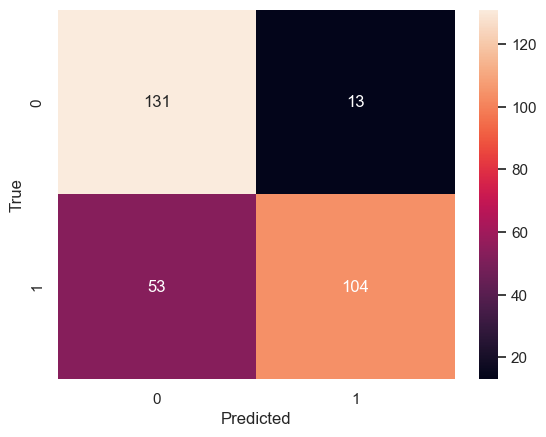

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
_, t_accuracy = best_model.evaluate(X_test, y_test)

# print accuracy
print("accuracy：", t_accuracy)

10/10 [==============================] - 0s 806us/step - loss: 0.5498 - accuracy: 0.7807
accuracy： 0.7807309031486511


In [28]:
# SHAP
shap.initjs()
explainer = shap.KernelExplainer(best_model, X_train)
nn_shap_values = explainer.shap_values(X_test)

Using 1200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/301 [00:00<?, ?it/s]

In [32]:
nn_shap_values[0]

array([[-2.18477481e-03, -8.07873028e-02, -1.31812793e-01,
        -8.28543633e-03,  2.06208974e-02],
       [-4.49090307e-04, -1.64413701e-01,  1.39646984e-01,
         2.07905467e-02, -6.82261307e-03],
       [ 3.52817938e-03,  1.14064551e-01,  2.44285957e-01,
         2.00705556e-02,  4.18877602e-03],
       ...,
       [ 1.02623726e-03,  3.74146579e-02,  2.69151567e-01,
         3.83328681e-02, -1.48048997e-02],
       [ 8.29909443e-05,  2.61547337e-02, -1.46257479e-01,
        -2.78094879e-02,  3.91463935e-03],
       [ 1.06569666e-03, -1.70154571e-01,  9.49667648e-02,
        -5.52668135e-03, -5.47689199e-03]])

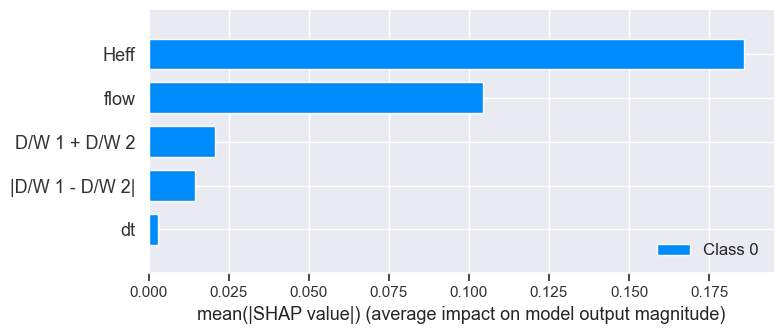

In [33]:
shap.summary_plot(nn_shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


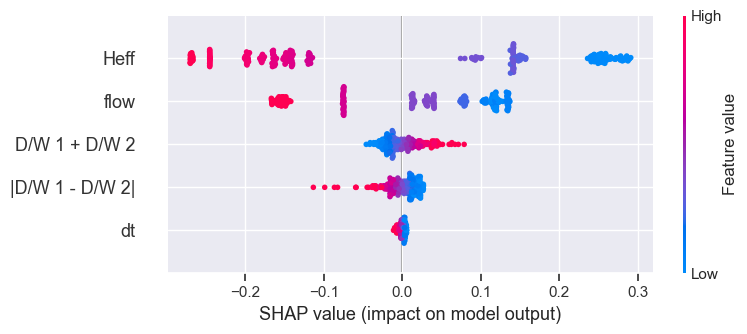

In [34]:
# split negative and positive shap values
nn_shap_values_positive = nn_shap_values[0]
nn_shap_values_negative = -nn_shap_values[0]

# create a list，store shap values for positive and negative class
nn_shap_values_list = [nn_shap_values_negative, nn_shap_values_positive]

# Summary Plot Deep-Dive on Label 1
shap.summary_plot(nn_shap_values_list[1], X_test)

In [35]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = ['No Coalescence', 'Coalescence']

# Get the feature names
feature_names = list(normalized_data.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, feature_names = feature_names,
                                 class_names = class_names, mode = 'classification')

In [36]:
# get prediction probability
def predict_proba(data):
    prediction = best_model.predict(data)
    return np.hstack((1 - prediction, prediction))

In [37]:
#Perform the explanation on the 8th instance in the test data
explaination = explainer.explain_instance(X_test.iloc[152], predict_proba)

# show the result of the model's explaination
explaination.show_in_notebook(show_table = True, show_all = False)

157/157 [==============================] - 0s 426us/step


In [30]:
y_test.iloc[152]

1